In [2]:
# DIPY & MRTRIX tracto extratcion
## Variables initialisation 
import nilearn 

In [1]:
SUBJ_ID="p_AR28"
NAS="tupac"
protocole="alexcis"
DIR_PATH="/NAS/"+NAS+"/protocoles/"+protocole
FS_PATH=DIR_PATH+"/FS53/"
DTI_PATH=FS_PATH+SUBJ_ID+"/dti/"
TRACTO="whole_brain_6_1500000"#"LongueFibres_SIFT"
TRACTO="LongueFibres"
MESH="lh.white.ras"
print DTI_PATH
!echo $DTI_PATH

/NAS/tupac/protocoles/alexcis/FS53/p_AR28/dti/
/NAS/tupac/protocoles/alexcis/FS53/p_AR28/dti/


In [2]:
fdwi = DTI_PATH+"20180323_100530WIPs3DT1ISO1mmHRSENSEs201a1002.nii.gz"
fbval = DTI_PATH+"20180323_100530WIPDTI64dir2mmSENSEs301a1003.bval"
fbvec = DTI_PATH+"20180323_100530WIPDTI64dir2mmSENSEs301a1003.bvec"

from dipy.io.image import load_nifti, save_nifti
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table
from dipy.reconst.dti import TensorModel

data, affine = load_nifti(fdwi)
bvals, bvecs = read_bvals_bvecs(fbval, fbvec)
gtab = gradient_table(bvals, bvecs)

tenmodel = TensorModel(gtab)
tenfit = tenmodel.fit(data)

save_nifti(DTI_PATH+"colorfa.nii.gz", tenfit.color_fa, affine)

In [3]:
print affine

[[  -2.            0.            0.          128.34214783]
 [   0.            2.            0.         -129.92842102]
 [   0.            0.            2.          -58.10770035]
 [   0.            0.            0.            1.        ]]


##  ROI for exclusion with freesurfer

In [3]:
!mri_extract_label $DTI_PATH"raparc.a2009s+aseg.nii" 46 47 7 8 15 16 251 252 253 254 255 $DTI_PATH"exclude_mask.nii"

reading volume from /NAS/tupac/protocoles/alexcis/FS53/p_AR28/dti/raparc.a2009s+aseg.nii...
extracting label 46 (Right_Cerebellum_White_Matter)
extracting label 47 (Right_Cerebellum_Cortex)
extracting label 7 (Left_Cerebellum_White_Matter)
extracting label 8 (Left_Cerebellum_Cortex)
extracting label 15 (Fourth_Ventricle)
extracting label 16 (Brain_Stem)
extracting label 251 (CC_Posterior)
extracting label 252 (CC_Mid_Posterior)
extracting label 253 (CC_Central)
extracting label 254 (CC_Mid_Anterior)
extracting label 255 (CC_Anterior)
writing output to /NAS/tupac/protocoles/alexcis/FS53/p_AR28/dti/exclude_mask.nii.


## MRtrix

In [8]:
!tckedit -force -exclude $DTI_PATH"exclude_mask.nii" $DTI_PATH$TRACTO".tck" $DTI_PATH"LongueFibres.tck"


tckedit: [WARNING] existing output files will be overwritten
tckedit: [done]  1500000 read,  1173117 written


In [10]:
!tckconvert -force $DTI_PATH$TRACTO".tck" $DTI_PATH$TRACTO".vtk"

tckconvert: [WARNING] existing output files will be overwritten
^C


## Nipype
conversion tck2trk 

In [5]:
TRACTO="LongueFibres"
import nipype.interfaces.mrtrix as mrt

tck2trk = mrt.MRTrix2TrackVis()
# whole_brain_6_1500000.tck eq .1.5M_SIFT.tck
tck2trk.inputs.in_file = DTI_PATH+TRACTO+".tck"
tck2trk.inputs.image_file = DTI_PATH+"/b0.nii"
tck2trk.inputs.out_filename = DTI_PATH+TRACTO+".trk"
tck2trk.run() 

170922-09:35:49,738 interface INFO:
	 Reading header data...
170922-09:35:49,788 interface INFO:
	 ...adding "0.3.15-264-g7372ab22" to header for key "mrtrix_version"
170922-09:35:49,789 interface INFO:
	 ...adding "1506064273.8148462772" to header for key "timestamp"
170922-09:35:49,790 interface INFO:
	 ...adding "exclude /NAS/tupac/protocoles/alexcis/FS53/p_AR28/dti/exclude_mask.nii" to header for key "roi"
170922-09:35:49,790 interface INFO:
	 ...adding "Float32LE" to header for key "datatype"
170922-09:35:49,791 interface INFO:
	 ...adding ". 252" to header for key "file"
170922-09:35:49,791 interface INFO:
	 ...adding "1173117" to header for key "count"
170922-09:35:49,792 interface INFO:
	 ...adding "1500000" to header for key "total_count"
170922-09:35:49,792 interface INFO:
	 Reached the end of the header!
170922-09:35:49,793 interface INFO:
	 Identifying the number of points per tract...
170922-09:36:25,857 interface INFO:
	 MRTrix Header:
170922-09:36:25,857 interface INFO:


## Nibabel
fibers loading

In [4]:
from nibabel import trackvis as tv
streams, hdr = tv.read(DTI_PATH+TRACTO+".trk")
streamlines = [i[0] for i in streams]

lecture d'un volume mesh

In [4]:
from nibabel import freesurfer as fs
white_mesh=fs.read_geometry(FS_PATH+SUBJ_ID+"/surf/"+MESH)

In [5]:
from dipy.utils.optpkg import optional_package
vtk, have_vtk, setup_module = optional_package('vtk')

In [6]:
import dipy.io.vtk as io_vtk
import dipy.viz.utils as ut_vtk
from dipy.viz import window, actor

my_polydata = vtk.vtkPolyData()
ut_vtk.set_polydata_vertices(my_polydata, white_mesh[0])
ut_vtk.set_polydata_triangles(my_polydata, white_mesh[1])

(vtkCommonDataModelPython.vtkPolyData)0x7f96efcfd188

In [12]:
file_name = DTI_PATH+"white_matter.vtk"
io_vtk.save_polydata(my_polydata, file_name)
print("Surface saved in " + file_name)

Surface saved in /NAS/tupac/protocoles/alexcis/FS53/p_AR28/dti/white_matter.vtk


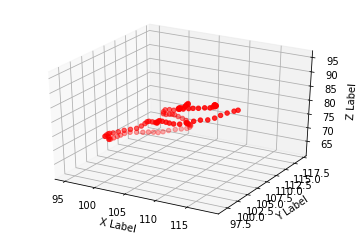

In [141]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(streamlines[0][:,0], streamlines[0][:,1],streamlines[0][:,2], c='r', marker='o')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

In [1]:
#cube_vertices = ut_vtk.get_polydata_vertices(my_polydata)
#colors = cube_vertices * 255
#ut_vtk.set_polydata_colors(cube_polydata, colors)
#print type(my_polydata)
#sphere1Tri = vtk.vtkTriangleFilter()
#sphere1Tri.SetInputData(my_polydata)

#print("new surface colors")
#print(ut_vtk.get_polydata_colors(cube_polydata))
# get vtkActor
cube_actor = ut_vtk.get_actor_from_polydata(my_polydata)

# renderer and scene
renderer = window.Renderer()
renderer.add(cube_actor)
renderer.set_camera(position=(0, 0, 0), focal_point=(0.5, 0.5, 0.5))
renderer.zoom(3)

#stream_actor = actor.line(streamlines)
#renderer.add(stream_actor)

#stream_vtk = io_vtk.load_polydata(DTI_PATH+TRACTO+".vtk")
#stream_actor = ut_vtk.get_actor_from_polydata(stream_vtk)
#renderer.add(stream_actor)
#sphere2Tri = vtk.vtkTriangleFilter()
#sphere2Tri.SetInputData(stream_vtk)

# create a transform that rotates the cone
#transform = vtk.vtkTransform()
#transform.Translate(100,-200,500)
#transform.RotateWXYZ(45,0,1,0)
#transformFilter=vtk.vtkTransformPolyDataFilter()
#transformFilter.SetTransform(transform)
#transformFilter.SetInputConnection(my_polydata.GetPro
#transformFilter.Update()

# mapper for original cone
#coneMapper1 = vtk.vtkPolyDataMapper()
#coneMapper1.SetInput(transformFilter.GetOutput())
#renderer.add(coneMapper1)


#booleanOperation = vtk.vtkBooleanOperationPolyDataFilter()
#booleanOperation.SetOperationToIntersection()
#booleanOperation.SetInputConnection(0, sphere1Tri.GetOutputPort())
#booleanOperation.SetInputConnection(1, sphere2Tri.GetOutputPort())
#booleanOperation.Update()

# display
window.show(renderer, size=(600, 600), reset_camera=False)
#window.record(renderer, out_path='cube.png', size=(600, 600))

NameError: name 'ut_vtk' is not defined

In [6]:
print len(streamlines[0])
print np.min(streamlines[0][:,0])
print np.max(streamlines[0][:,0])

print np.min(streamlines[0][:,1])
print np.max(streamlines[0][:,1])

print np.min(streamlines[0][:,2])
print np.max(streamlines[0][:,2])

print streamlines[0][0,:]-streamlines[0][1,:]

ImportError: No module named pyopencl

In [1]:
import numpy as np

Xmin=[];
Xmax=[];
Ymin=[];
Ymax=[];
Zmin=[];
Zmax=[];

for cpt in np.arange(1,len(streamlines)):
    Xmax.append(np.max(streamlines[cpt][:,0]))
    Xmin.append(np.min(streamlines[cpt][:,0]))
    Ymax.append(np.max(streamlines[cpt][:,1]))
    Ymin.append(np.min(streamlines[cpt][:,1]))
    Zmax.append(np.max(streamlines[cpt][:,2]))
    Zmin.append(np.min(streamlines[cpt][:,2]))

print np.max(Xmax)
print np.min(Xmin)
print np.max(Ymax)
print np.min(Ymin)
print np.max(Zmax)
print np.min(Zmin)

print np.max(white_mesh[0][:,0])
print np.min(white_mesh[0][:,0])
print np.max(white_mesh[0][:,1])
print np.min(white_mesh[0][:,1])
print np.max(white_mesh[0][:,2])
print np.min(white_mesh[0][:,2])

T=np.array([[0.9993,-0.0243,-0.0289,-0.1074],[0.0237,0.9995,-0.0224,-0.0150],[0.0294,0.0217,0.9993,1.7368],[0,0,0,1.0000]])
x=np.ones((len(white_mesh[0]),1),dtype=float);
test=np.concatenate((white_mesh[0],x),axis=1)
print test.shape
X=np.dot(test,T)

NameError: name 'streamlines' is not defined

In [ ]:
print type(cube_polydata)
print cube_polydata
print type(cube_vertices)


In [103]:
import numpy as np
mat = np.mat(white_mesh[0][:])
print (white_mesh[0][:]).shape
print np.ones((99490,1)).shape
cool = np.concatenate((white_mesh[0][:],np.ones((99490,1))),axis=1)
print cool.shape


(99490, 3)
(99490, 1)
(99490, 4)


In [59]:
test2=get_affine_trackvis_to_rasmm(streamlines)


NameError: name 'get_affine_trackvis_to_rasmm' is not defined

In [54]:
import nibabel as nib
print DTI_PATH+"LongueFibres_SIFT.tck"
tck = nib.streamlines.is_correct_format(DTI_PATH+"LongueFibres_SIFT.tck");
print tck

import nipype.interfaces.mrtrix as mrt
filt = mrt.FilterTracks()
filt.inputs.in_file = DTI_PATH+'LongueFibres_SIFT.tck'
filt.run()   

/NAS/tupac/protocoles/alexcis/FS53/t_AD25/dti/LongueFibres_SIFT.tck


AttributeError: 'module' object has no attribute 'is_correct_format'

## DIPY
QuickBundles

In [17]:
from dipy.segment.metric import ResampleFeature
from dipy.segment.metric import AveragePointwiseEuclideanMetric
from dipy.segment.metric import CenterOfMassFeature
from dipy.segment.metric import EuclideanMetric
from dipy.segment.metric import IdentityFeature
from dipy.segment.clustering import QuickBundles
from dipy.tracking.streamline import set_number_of_points

# Make sure our streamlines have the same number of points.
#streamlines = set_number_of_points(streamlines, nb_points=12)

feature = ResampleFeature(nb_points=240)
#feature = IdentityFeature()
#feature = CenterOfMassFeature()
#metric = EuclideanMetric(feature)
metric = AveragePointwiseEuclideanMetric(feature=feature)  # a.k.a. MDF
qb = QuickBundles(threshold=10, metric=metric)
qb.max_nb_clusters = 8
clusters = qb.cluster(streamlines)
print clusters.centroids[0][1]

[ 146.12109375   65.11854553   54.90721512]


('Nb. clusters:', 4)
('Cluster sizes:', [252823, 250402, 341347, 328545])
[252823, 250402, 341347, 328545]
3


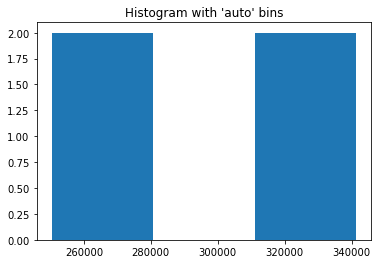

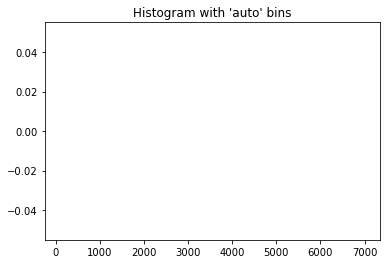

In [15]:
import matplotlib.pyplot as plt
print("Nb. clusters:", len(clusters))
test=map(len, clusters)
print("Cluster sizes:", test)
print clusters.clusters_sizes()
print len(streamlines[0:3]) 
plt.hist(test, bins='auto')  
plt.title("Histogram with 'auto' bins")
plt.show()

plt.hist(clusters.clusters_sizes(), bins='auto',range=(100,7000))  
plt.title("Histogram with 'auto' bins")
plt.show()

visualisation

In [2]:
from dipy.viz import fvtk
ren = fvtk.ren()
ren.SetBackground(0, 0, 0)
#fvtk.add(ren, fvtk.streamtube(streamlines,fvtk.colors.white,linewidth=0.2,opacity=0.1));
#fvtk.add(ren, fvtk.streamtube(clusters[0],fvtk.colors.white,linewidth=0.2,opacity=0.1));
#fvtk.add(ren, fvtk.streamtube(clusters[1],fvtk.colors.red,linewidth=0.2,opacity=0.1));
#fvtk.add(ren, fvtk.streamtube(clusters[2],fvtk.colors.green,linewidth=0.2,opacity=0.1));
#fvtk.add(ren, fvtk.streamtube(clusters[3],fvtk.colors.blue,linewidth=0.2,opacity=0.1));
fvtk.add(ren, fvtk.streamtube(clusters.centroids,linewidth=1));
fvtk.show(ren)

NameError: name 'clusters' is not defined

In [1]:
ren = fvtk.ren()
import numpy as np
colormap = fvtk.create_colormap(np.arange(1))
print colormap
ren.SetBackground(0, 0, 0)
fvtk.add(ren, fvtk.streamtube(clusters.centroids,linewidth=0.5));

fvtk.add(ren, fvtk.streamtube(clusters[0],fvtk.colors.white,linewidth=0.2,opacity=0.1));
fvtk.add(ren, fvtk.streamtube(clusters[1],fvtk.colors.red,linewidth=0.2,opacity=0.1));
fvtk.add(ren, fvtk.streamtube(clusters[2],fvtk.colors.green,linewidth=0.2,opacity=0.1));
fvtk.add(ren, fvtk.streamtube(clusters[3],fvtk.colors.blue,linewidth=0.2,opacity=0.1));

#lines = [np.random.rand(10, 3), np.random.rand(20, 3)]
#fvtk.add(ren, fvtk.streamtube(lines));
fvtk.show(ren)
#fvtk.record(ren, n_frames=1, out_path="/NAS/"+NAS+"/protocoles/"+protocole+"/FS53/"+subject+"/dti/CC_clusters.png", size=(600, 600))

NameError: name 'fvtk' is not defined

In [ ]:
ren = fvtk.ren()
#colormap = fvtk.create_colormap(np.arange(len(clusters)))
ren.SetBackground(0, 0, 0)#colormap[60:65]
fvtk.add(ren, fvtk.streamtube(streamlines,fvtk.colors.white,linewidth=0.2,opacity=0.1));
fvtk.show(ren)

#fvtk.add(ren, fvtk.streamtube(clusters.centroids,fvtk.colors.white, linewidth=0.4))
#fvtk.record(ren, n_frames=1, out_path='/NAS/tupac/protocoles/healthy_volunteers/FS53/T02S01/dti/whole_brain_clusters_60_2.png', size=(600, 600))